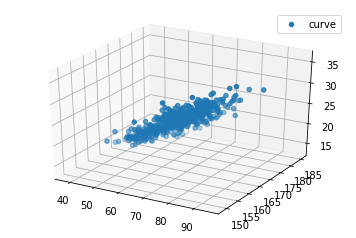

[62.34726813] [166.45278587] [22.23686099]


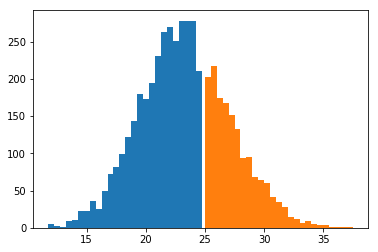

torch.Size([5000, 4]) torch.Size([5000, 1])


  7%|▋         | 79667/1080000 [18:18<3:57:32, 70.19it/s, loss: 1.296, val_loss: 1.1108, att_loss : 0.525, regularizer : 0.002                     0.503, ,0.495, ,0.001, ,0.000, l1 0.005, entropy 2.000]  

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.preprocessing
from tqdm import tqdm
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
        assert len(X) == len(Y)
        
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]

def generator(dataloader):
    while True:
        for data in dataloader:
            yield data


eps = np.finfo(float).eps

def plot_hist(arr, width=0.5):
    plt.hist(arr, bins=np.arange(min(arr),max(arr), width))
def F_bmi(w, h):
    return w / np.power(h/100., 2)

def F1(x):
    return 1.3*np.power(x, 3) + 2*x - 17
def F2(x, y):
    return x*x + 3
def F3(x, y):
    return -0.2*x*y + 3*y + 15
def F4(x, y):
    return -2*x + y

N = 5000


iid = np.random.normal(77, 16, size=[N,1])
iid2 = np.random.normal(22, 2, size=[N,1])
h = np.random.normal(167, 5.7, size=[N,1]) 
w = np.random.normal(64.8, 8.9, size=[N,1])
# h = np.random.uniform(60, 250, size=[N,1]) 
# w = np.random.uniform(30, 200, size=[N,1])

h = np.clip(h, 40, 240)
w = np.clip(w, 20, 200)
bmi = F_bmi(w, h)

x1 = np.random.uniform(-10, 10, size=[N, 1])
y1 = F1(x1)

x2 = np.random.normal(-30, 10, size=[N, 1])
y2 = F2(x1, y1)
y3 = F3(x1, x2)
y4 = F4(y1, y2)


# noise
small_noise = np.random.normal(0, 1, size=[N,1])
# median_noise = np.random.normal(0, 5, size=[N,1])
# median_noise = np.random.normal(0, 5, size=[N,1])
bmi = bmi+small_noise


fig = plt.figure()
ax = fig.gca(projection='3d')
# ax = fig.gca()
# ax.scatter(x1.flatten(), y4.flatten(), label='curve')
# ax.scatter(x1.flatten(), y1.flatten(), label='curve')
# ax.scatter(x1.flatten(), y1.flatten(), y2.flatten(), label='curve')
ax.scatter(w.flatten()[:500], h.flatten()[:500], bmi.flatten()[:500], label='curve')
# ax.scatter(w.flatten(), h.flatten(), label='curve')
# ax.plot(x1.flatten(), y1.flatten(), y2.flatten(), label='curve')
# ax.scatter(x1.flatten(), x2.flatten(), y2.flatten(), 'b.')
# ax.scatter(h.flatten(), w.flatten(), bmi.flatten(), 'b.')
ax.legend()

plt.show()



print w[0], h[0],bmi[0]
plot_hist(bmi[np.where(bmi<=25)])
plot_hist(bmi[np.where(bmi>25)])
plt.show()


X = torch.from_numpy(np.hstack([h, w, iid, iid2]).astype(np.float32))
# X = torch.from_numpy(np.hstack([x1, x2, y1, y2, y3, iid, iid2]).astype(np.float32))
# X = torch.from_numpy(np.hstack([x1, x2, y1, y2, y3, iid, iid2]).astype(np.float32))

# X = torch.from_numpy(x1.astype(np.float32))
# X = torch.from_numpy(np.hstack([x1, iid]).astype(np.float32))
# X, norm = sklearn.preprocessing.normalize(X, axis=0, return_norm=True)
# X = X.astype(np.float32)
# print norm.shape
Y = torch.from_numpy(bmi.astype(np.float32))
# Y = torch.from_numpy(y4.astype(np.float32))
# Y = torch.from_numpy((bmi > 25).astype(np.float32))
print X.shape, Y.shape
batch_size = 128
train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)


eps = np.finfo(float).eps

class Autoendecoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, depth, act_fn):
        super(Autoendecoder, self).__init__()
        
        self.act_fn = act_fn
        self.en = nn.ModuleList()
        self.en.append(nn.Linear(in_dim, hidden_dim))
        self.norms = nn.ModuleList(nn.BatchNorm1d(hidden_dim) for i in range(depth))
        for i in range(depth-1):
            self.en.append(nn.Linear(hidden_dim, hidden_dim))
        self.out = nn.Linear(hidden_dim, 1)

#         for regularizer
        self.kernel_weights = []
        for linear in self.en:
            self.kernel_weights.append(linear.weight)
        self.kernel_weights.append(self.out.weight)
        

    def forward(self, x):
        for lay, norm in zip(self.en, self.norms):
            x = self.act_fn(lay(x))
#             x = norm(x)
        y = self.out(x)
        return y
    
class Attention_Autoendecoder(nn.Module):
    def __init__(self, in_dim):
        super(Attention_Autoendecoder, self).__init__()
        self.w = nn.Parameter(torch.ones([1, in_dim], dtype=torch.float)*1)
        self.w.requires_grad_(True)
#         self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.relu)
#         self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.leaky_relu)
#         self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.relu)
        self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.selu)
        self.kernel_weights = self.AE.kernel_weights
    def forward(self, x):
        batch, _ = x.shape
        att_w = torch.sigmoid(self.w)
#         att_w = self.w
#         att_w = torch.softmax(self.w, dim=-1)

#         att_w = torch.FloatTensor([1, 1, 1, 1]).view(1,-1).cuda()
        x = (att_w / torch.sum(att_w)).repeat(batch, 1) * x
        y = self.AE(x)
#         att_w = torch.softmax(att_w, dim=1)
        return y, att_w
    
def entropy_loss(x):
    N = x.shape[0]
    loss = 0
    for i in range(x.shape[-1]):
        a = x[:, i]
        loss += torch.sum(-a*torch.log2(a+eps))
    return loss / N

def regularizer(kernel_weights, loss_fn):
    reg_loss = 0
    for w in kernel_weights:
        reg_loss += loss_fn(torch.zeros_like(w), w)
    return reg_loss

def mask_column(X, col_idx):
    assert len(X.shape) == 2
    ret = X.clone()
    ret[:, col_idx] = 0
    return ret
    


model = Attention_Autoendecoder(X.shape[-1]).cuda()
# opt = optim.Adam(model.parameters(), lr=0.01)
opt = optim.Adam(model.parameters())
alpha = 100
beta = 0
epochs = 30000
iters = 1
writer = SummaryWriter('./AE_logs/noised_bmi-a%f,b%f' % (alpha, beta))
reg_l2_coe = 0.1
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
        mask_idx = np.random.randint(0, X.shape[-1])
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            x, y = x.cuda(), y.cuda()
            val_x, val_y = next(val_G)
            val_x, val_y = val_x.cuda(), val_y.cuda()
#             mask
#             x = mask_column(x, mask_idx)
#             val_x = mask_column(val_x, mask_idx)
# 
            model.train()
            out, att_w = model(x)
            w_ = torch.softmax(att_w, dim=-1)
            mse_loss = F.mse_loss(out, y)
#             att_loss = alpha*(F.l1_loss(att_w, torch.zeros_like(att_w)) + beta*entropy_loss(F.softmax(att_w, dim=-1)))
            att_loss = alpha*(F.l1_loss(att_w, torch.zeros_like(att_w)) + beta*entropy_loss(w_))
            reg_loss = reg_l2_coe * regularizer(model.kernel_weights, F.mse_loss)
            loss = att_loss + mse_loss + reg_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            with torch.no_grad():
                model.eval()
                out, _ = model(val_x)
                val_mse_loss = F.mse_loss(out, val_y)
#                 val_att_loss = F.l1_loss(val_att_w, torch.zeros_like(val_att_w))
#                 val_att_loss = entropy_loss(F.softmax(val_att_w, dim=1))
#                 val_att_loss = F.l1_loss(val_att_w, torch.zeros_like(val_att_w)) + beta*entropy_loss(F.softmax(val_att_w, dim=1))
            
                val_loss = att_loss + val_mse_loss + reg_loss
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            att_w_arr = att_w.cpu().detach().numpy().flatten()
            ratio_w = (att_w / torch.sum(att_w)).cpu().detach().numpy().flatten()
#             buf = ','.join(['%d:%.2f' % (i+1,x) for i,x in enumerate(buf)])
            buf = ','.join(['%2.3f, ' % (x) for i,x in enumerate(ratio_w)])
            buf += 'l1 %.3f, entropy %.3f' % (F.l1_loss(att_w, torch.zeros_like(att_w)).item(), entropy_loss(w_).item())
            pbar.set_postfix_str('loss: %.3f, val_loss: %.4f, att_loss : %.3f, regularizer : %.3f                     %s' %
                                 (mse_loss.item(), val_mse_loss.item(), 
                                  att_loss.item(),
                                  reg_loss.item(), buf))
#             if mse_loss.item() < 100:
            if epoch > 0:
                writer.add_scalars('data/loss', {'train': loss.item(),
                                                     'validation': val_loss.item()},
                                                     iters)
                writer.add_scalars('data/mse_loss', {'train': mse_loss.item(),
                                                     'validation': val_mse_loss.item()},
                                                     iters)
                writer.add_scalars('data/att_loss', {'train': att_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/att_w', {'w%d' % (i+1) : v  for i, v in enumerate(att_w_arr)},
                                                     iters)
                writer.add_scalars('data/ratio_att_w', {'w%d' % (i+1) : v  for i, v in enumerate(ratio_w)},
                                                     iters)
            
            iters += 1

print 'done 1'

writer.close()

print 'done'

print att_w[0,: ]

In [4]:
att_model = model


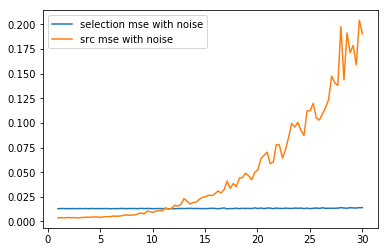

In [14]:
def eval_noise(model, val_G, label, iters=100):
    x_ax = np.linspace(1, 30, 100)
    src_arr = []
    noised_arr = []
    for std in x_ax:
        src_mse_loss = 0
        noised_mse_loss = 0
        normal = torch.distributions.Normal(0, std)
        for i in range(iters):
            val_x, val_y = next(val_G)
            val_x, val_y = val_x.cuda(), val_y.cuda()
            N = val_x.shape[0]
            noise = torch.cat([torch.zeros_like(val_x)[:,:-2], normal.sample([N,2]).cuda()], dim=1)
            out1,_ = model(val_x)
            out2,_ = model(val_x + noise)
            src_mse_loss += F.mse_loss(out1, val_y)
            noised_mse_loss += F.mse_loss(out2, val_y)
        src_mse_loss /= iters
        noised_mse_loss /= iters
        src_arr.append(src_mse_loss.item())
        noised_arr.append(noised_mse_loss.item())
    
#     plt.plot(x_ax, src_arr, label=label + ' mse')
    plt.plot(x_ax, noised_arr, label=label + ' mse with noise')
eval_noise(att_model, val_G, 'selection', 10)
eval_noise(model, val_G, 'src', 10 )
plt.legend()
plt.show()

Iris data set

In [18]:
print X.shape, Y.shape
print Y

(150, 4) (150, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]


In [21]:
from sklearn.datasets import load_iris
from sklearn import tree

class Attention_Classifier(nn.Module):
    def __init__(self, in_dim):
        super(Attention_Classifier, self).__init__()
        self.w = nn.Parameter(torch.ones([1, in_dim], dtype=torch.float)*1)
        self.w.requires_grad_(True)
#         self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.relu)
#         self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.leaky_relu)
#         self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.relu)
        self.AE = Autoendecoder(in_dim, hidden_dim=1024, depth=3, act_fn=F.selu)
        self.kernel_weights = self.AE.kernel_weights
    def forward(self, x):
        batch, _ = x.shape
        att_w = torch.sigmoid(self.w)
#         att_w = self.w
#         att_w = torch.softmax(self.w, dim=-1)

#         att_w = torch.FloatTensor([1, 1, 1, 1]).view(1,-1).cuda()
        x = (att_w / torch.sum(att_w)).repeat(batch, 1) * x
        y = self.AE(x)
#         att_w = torch.softmax(att_w, dim=1)
        return y, att_w

iris = load_iris()
X = iris.data.astype(np.float32)
Y = iris.target.reshape([-1, 1]).astype(np.float32)
# print iris.data.shape
N = len(Y)
batch_size = 32
train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

model = Attention_Autoendecoder(X.shape[-1]).cuda()
# opt = optim.Adam(model.parameters(), lr=0.01)
opt = optim.Adam(model.parameters())
alpha = 100
beta = 0
epochs = 3000000
iters = 1
writer = SummaryWriter('./AE_logs/Iris-a%f,b%f' % (alpha, beta))
reg_l2_coe = 0.1
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
        mask_idx = np.random.randint(0, X.shape[-1])
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            x, y = x.cuda(), y.cuda()
            val_x, val_y = next(val_G)
            val_x, val_y = val_x.cuda(), val_y.cuda()
#             mask
#             x = mask_column(x, mask_idx)
#             val_x = mask_column(val_x, mask_idx)
# 
            model.train()
            out, att_w = model(x)
            w_ = torch.softmax(att_w, dim=-1)
            mse_loss = F.mse_loss(out, y)
#             att_loss = alpha*(F.l1_loss(att_w, torch.zeros_like(att_w)) + beta*entropy_loss(F.softmax(att_w, dim=-1)))
            att_loss = alpha*(F.l1_loss(att_w, torch.zeros_like(att_w)) + beta*entropy_loss(w_))
            reg_loss = reg_l2_coe * regularizer(model.kernel_weights, F.mse_loss)
            loss = att_loss + mse_loss + reg_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            with torch.no_grad():
                model.eval()
                out, _ = model(val_x)
                val_mse_loss = F.mse_loss(out, val_y)
#                 val_att_loss = F.l1_loss(val_att_w, torch.zeros_like(val_att_w))
#                 val_att_loss = entropy_loss(F.softmax(val_att_w, dim=1))
#                 val_att_loss = F.l1_loss(val_att_w, torch.zeros_like(val_att_w)) + beta*entropy_loss(F.softmax(val_att_w, dim=1))
            
                val_loss = att_loss + val_mse_loss + reg_loss
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            att_w_arr = att_w.cpu().detach().numpy().flatten()
            ratio_w = (att_w / torch.sum(att_w)).cpu().detach().numpy().flatten()
#             buf = ','.join(['%d:%.2f' % (i+1,x) for i,x in enumerate(buf)])
            buf = ','.join(['%2.3f, ' % (x) for i,x in enumerate(ratio_w)])
            buf += 'l1 %.3f, entropy %.3f' % (F.l1_loss(att_w, torch.zeros_like(att_w)).item(), entropy_loss(w_).item())
            pbar.set_postfix_str('loss: %.3f, val_loss: %.4f, att_loss : %.3f, regularizer : %.3f                     %s' %
                                 (mse_loss.item(), val_mse_loss.item(), 
                                  att_loss.item(),
                                  reg_loss.item(), buf))
#             if mse_loss.item() < 100:
            if epoch > 0:
                writer.add_scalars('data/loss', {'train': loss.item(),
                                                     'validation': val_loss.item()},
                                                     iters)
                writer.add_scalars('data/mse_loss', {'train': mse_loss.item(),
                                                     'validation': val_mse_loss.item()},
                                                     iters)
                writer.add_scalars('data/att_loss', {'train': att_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/att_w', {'w%d' % (i+1) : v  for i, v in enumerate(att_w_arr)},
                                                     iters)
                writer.add_scalars('data/ratio_att_w', {'w%d' % (i+1) : v  for i, v in enumerate(ratio_w)},
                                                     iters)
            
            iters += 1

print 'done 1'

writer.close()

print 'done'

print att_w[0,: ]


  0%|          | 2353/15000000 [00:28<51:17:24, 81.22it/s, loss: 0.036, val_loss: 0.0209, att_loss : 21.284, regularizer : 0.008                     0.253, ,0.249, ,0.249, ,0.249, l1 0.213, entropy 2.000]


KeyboardInterrupt: 

In [3]:
src_mse_loss = 0
noised_mse_loss = 0
normal = torch.distributions.Normal(0, 20)

for i in range(100):
    val_x, val_y = next(val_G)
    val_x, val_y = val_x.cuda(), val_y.cuda()
    N = val_x.shape[0]
    noise = torch.cat([torch.zeros_like(val_x)[:,:-2], normal.sample([N,2]).cuda()], dim=1)
    out1,_ = model(val_x)
    out2,_ = model(val_x + noise)
    src_mse_loss += F.mse_loss(out1, val_y)
    noised_mse_loss += F.mse_loss(out2, val_y)
    
print src_mse_loss
print noised_mse_loss


tensor(0.2820, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2940, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
torch.softmax(torch.FloatTensor([1,0,0]), dim=0)
              

In [5]:
import keras
from keras.models import *
from keras.layers import *

input_x = np.hstack([h, w, iid, iid2])
print input_x.shape
m = Sequential()
m.add(Dense(32, activation='selu'))
m.add(Dense(32, activation='selu'))
m.add(Dense(1, activation='linear'))
m.compile(loss='mse', optimizer='adam')
m.fit(input_x, bmi, epochs=100, batch_size=128, validation_split=0.1)
m.summary()

(5000, 4)
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 0s 94us/step - loss: 164.5978 - val_loss: 35.5823
Epoch 2/100
4500/4500 [==============================] - 0s 10us/step - loss: 26.3120 - val_loss: 21.2340
Epoch 3/100
4500/4500 [==============================] - 0s 10us/step - loss: 18.7055 - val_loss: 16.4996
Epoch 4/100
4500/4500 [==============================] - 0s 10us/step - loss: 13.3884 - val_loss: 11.8063
Epoch 5/100
4500/4500 [==============================] - 0s 10us/step - loss: 9.3696 - val_loss: 8.5097
Epoch 6/100
4500/4500 [==============================] - 0s 10us/step - loss: 6.4847 - val_loss: 5.7052
Epoch 7/100
4500/4500 [==============================] - 0s 10us/step - loss: 4.5516 - val_loss: 4.2466
Epoch 8/100
4500/4500 [==============================] - 0s 10us/step - loss: 3.6111 - val_loss: 3.6114
Epoch 9/100
4500/4500 [==============================] - 0s 10us/step - loss: 3.2435 - val_loss: 3.442

In [ ]:
print x1.shape
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x1.flatten(), y1.flatten(), y2.flatten(), label='curve')
ax.legend()
print X.shape
plt.show()

In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
ax.plot(x, y, z, label='parametric curve')
ax.legend()

plt.show()